In [1]:
from keras.datasets import mnist
import numpy as np
from  matplotlib import pyplot as plt
import time
import math
from sklearn.model_selection import train_test_split

In [2]:
dataset= mnist.load_data()
(X_train_and_validation, y_train_and_validation), (X_test, y_test) = dataset
X_train, X_validation, y_train, y_validation = train_test_split(X_train_and_validation, y_train_and_validation, test_size=0.1, random_state=42)
X_train = (X_train/255.0).astype(np.float32)
X_validation = (X_validation/255.0).astype(np.float32)
X_test = (X_test/255.0).astype(np.float32)

X_train = np.array(X_train.reshape(X_train.shape[0], 784,1))         
X_test = np.array(X_test.reshape(X_test.shape[0], 784,1))
X_validation = np.array(X_validation.reshape(X_validation.shape[0], 784,1))

11501568/11490434 [==============================] - 0s 0us/step


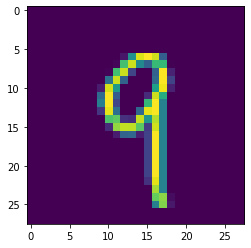

In [7]:
plt.imshow(X_train[78].reshape(28,28))

In [10]:
labels = {0:'0', 1: '1', 2:'2', 3:'3', 4:'4', 5:'5', 6:'6', 7:'7', 8:'8', 9:'9'}

In [11]:
#Activation function
def activation(activation_function):
  if activation_function == 'sigmoid':
    return sigmoid
  if activation_function == 'tanh':
    return tanh
  if activation_function == 'ReLU':
    return relu

def sigmoid(x, derivative = False):
  if derivative:
    return sigmoid(x)*(1-sigmoid(x))
  return 1/(1 + np.exp(-x))  

def tanh(x, derivative = False):
  if derivative:
    return 1 - tanh(x)**2
  return (np.exp(x)-np.exp(-x))/(np.exp(x)+np.exp(-x))

def relu(x, derivative = False):
  if derivative:
    return (x>0)*1 
  return x*(x>0)

def softmax(x,derivative = False):
  if derivative:
    return softmax(x)*(1- softmax(x))
  return np.exp(x)/np.sum(np.exp(x), axis = 0)

def one_hot(y, num_output_nodes):
  v = np.zeros((num_output_nodes, len(y)))
  for i,j in enumerate(y):
    v[j,i] = 1
  return v

In [13]:
### Weight Initialization
def param_inint(num_inputs_nodes, hidden_layers, num_output_nodes, init_type):
  W = []
  B = []
  if init_type == "random":
    W.append(np.random.randn(hidden_layers[0],num_inputs_nodes)*0.1)
    B.append(np.random.randn(hidden_layers[0], 1)*0.1)
    for i in range(len(hidden_layers)-1):
      W.append(np.random.randn(hidden_layers[i+1],hidden_layers[i])*0.1)
      B.append(np.random.randn(hidden_layers[i+1], 1)*0.1)
    W.append(np.random.randn(num_output_nodes, hidden_layers[-1])*0.1)
    B.append(np.random.randn(num_output_nodes, 1)*0.1)
    return W, B

  if init_type == "xavier":
    W.append(np.random.randn(hidden_layers[0],num_inputs_nodes)*np.sqrt(2/(hidden_layers[0] + num_inputs_nodes)))
    B.append(np.random.randn(hidden_layers[0], 1)*0.1)
    for i in range(len(hidden_layers)-1):
      W.append(np.random.randn(hidden_layers[i+1],hidden_layers[i])*np.sqrt(2/(hidden_layers[i+1] + hidden_layers[i])))
      B.append(np.random.randn(hidden_layers[i+1], 1)*0.1)
    W.append(np.random.randn(num_output_nodes, hidden_layers[-1])*np.sqrt(2/(num_output_nodes + hidden_layers[-1])))
    B.append(np.random.randn(num_output_nodes, 1)*0.1)
    return W, B


#### Feed forward and Back Prop

In [14]:
def feed_forward(x, W, B, activation_type):
  h = []
  a = []
  sigma = activation(activation_type)  #activation
  h.append(x)   #h0 = x
  a.append(np.dot(W[0], h[0]) + B[0])
  for i in range(len(W)-1):
    h.append(sigma(a[-1]))
    a.append(np.dot(W[i+1], h[-1]) + B[i+1])
  y_hat = softmax(a[-1])

  return y_hat, h, a

def loss_compute(y,y_hat, loss_type, W, reg_lamda):
  if loss_type == "squared_error":
    error = np.sum((one_hot(y, 10)-y_hat)**2)/(2*one_hot(y, 10).shape[1])
  if loss_type == "cross_entropy":
    error = -1*np.sum(np.multiply(one_hot(y, 10),np.log(y_hat)))/one_hot(y, 10).shape[1]         # hardcoded classes = 10

  if W:
    r = 0
    for i in range(len(W)):
      r += np.sum((np.array(W, dtype = object) **2)[i])
    error = error + reg_lamda * r

  return error

def back_prop(x, y, y_hat, a, h , W, B, batch_size, loss_type, activation_type):
  gh = [0]*len(h)
  ga = [0]*len(a)
  gw = [0]*len(W)
  gb = [0]*len(B)

  sigma = activation(activation_type) 

  if loss_type == "cross_entropy":
    gh[-1] = -1*(y/y_hat)
    ga[-1] = -1*(y-y_hat)
  if loss_type == "squared_error":   ##### edit this
    gh[-1] = y_hat - y
    ga[-1] = (y_hat - y)*softmax(a[-1])*(1-softmax(a[-1]))

  for i in range(len(W)-1, -1, -1):
    gw[i] = np.dot(ga[i], h[i].T)
    gb[i] = np.dot(ga[i], np.ones((batch_size,1)))
    if i > 0:
      gh[i-1] = np.dot(W[i].T, ga[i])
      ga[i-1]  = np.multiply(gh[i-1],sigma(a[i-1], derivative = True))

  return gw, gb, gh, ga

def accuracy(y_hat, y_true):
  return np.mean(np.argmax(y_hat, axis = 0) ==y_true )*100



In [15]:
class SGD:
  ''' Stochastic Gradient Descent '''
  def __init__(self, lr = 0.001, reg = 0):
    self.lr = lr
    self.reg = reg
  
  def update(self, w,b, gW, gB):
    W = np.array(w, dtype = object)
    B = np.array(b, dtype = object)

    W = (1-self.lr*self.reg)*W - self.lr * np.array(gW, dtype = object)
    B = (1-self.lr*self.reg)*B - self.lr * np.array(gB, dtype = object)

    return W.tolist(),B.tolist()


class Momentum:

  def __init__(self, lr = 0.001, gamma = 0.9, reg = 0):
    self.lr = lr
    self.gamma = gamma
    self.Wmoments = None
    self.Bmoments = None
    self.reg = reg


  def update(self, w,b, gW, gB):
    params = {'w':w, 'b':b}

    if self.Wmoments == None:
      self.Wmoments = [0] * len(params['w'])
      for i in range(len(params['w'])):
        self.Wmoments[i] = np.zeros_like(params['w'][i])

    if self.Bmoments == None:
      self.Bmoments = [0] * len(params['b'])
      for i in range(len(params['b'])):
        self.Bmoments[i] = np.zeros_like(params['b'][i])
    
    self.Wmoments = self.gamma * np.array(self.Wmoments, dtype = object) + self.lr * np.array(gW, dtype = object)
    W = (1-self.lr*self.reg)*np.array(params['w'], dtype = object) - self.Wmoments
    self.Wmoments = self.Wmoments.tolist()

    self.Bmoments = self.gamma * np.array(self.Bmoments, dtype = object) + self.lr * np.array(gB, dtype = object)
    B = (1-self.lr*self.reg)*np.array(params['b'], dtype = object) - self.Bmoments
    self.Bmoments = self.Bmoments.tolist()
    
    return W.tolist(), B.tolist()


class AdaGrad:
  def __init__(self, lr=0.01):
    self.lr = lr
    self.vW = None
    self.vB = None
    self.reg = None
      
  def update(self, w,b, gW, gB):
    params = {'w':w, 'b':b}

    if self.vW == None:
      self.vW = [0] * len(params['w'])
      for i in range(len(params['w'])):
          self.vW[i] = np.zeros_like(params['w'][i])

    if self.vB == None:
      self.vB = [0] * len(params['b'])
      for i in range(len(params['b'])):
          self.vB[i] = np.zeros_like(params['b'][i])

    self.vW = np.array(self.vW, dtype = object) + np.array(gW, dtype = object) **2 
    W = (1-self.lr*self.reg)*np.array(params['w'], dtype = object) - (self.lr/((self.vW + 1e-7)**0.5)) * np.array(gW, dtype = object)
    self.vW = self.vW.tolist()

    self.vB = np.array(self.vB, dtype = object) + np.array(gB, dtype = object) **2 
    B = (1-self.lr*self.reg)*np.array(params['b'], dtype = object) - (self.lr/((self.vB + 1e-7)**0.5)) * np.array(gB, dtype = object)
    self.vB = self.vB.tolist()

    return W.tolist(), B.tolist()

class RMSprop:
  def __init__(self, lr=0.01, beta = 0.99):
    
    self.lr = lr
    self.vW = None
    self.vB = None
    self.beta = beta
    self.reg = None

  def update(self, w,b, gW, gB):
    params = {'w':w, 'b':b}
    if self.vW == None:
      self.vW = [0] * len(params['w'])
      for i in range(len(params['w'])):
        self.vW[i] = np.zeros_like(params['w'][i])

    if self.vB == None:
      self.vB = [0] * len(params['b'])
      for i in range(len(params['b'])):
        self.vB[i] = np.zeros_like(params['b'][i])

    self.vW = self.beta*np.array(self.vW, dtype = object) + (1-self.beta)*(np.array(gW, dtype = object) **2) 
    W = (1-self.lr*self.reg)*np.array(params['w'], dtype = object) - (self.lr/((self.vW + 1e-7)**0.5)) * np.array(gW, dtype = object)
    self.vW = self.vW.tolist()

    self.vB = self.beta*np.array(self.vB, dtype = object) + (1-self.beta)*(np.array(gB, dtype = object) **2 )
    B = (1-self.lr*self.reg)*np.array(params['b'], dtype = object) - (self.lr/((self.vB + 1e-7)**0.5)) * np.array(gB, dtype = object)
    self.vB = self.vB.tolist()

    return W.tolist(), B.tolist()

class Nesterov:   
  def __init__(self, lr=0.01, gamma=0.9):
    self.lr = lr
    self.reg = None
    self.gamma = gamma                                                             
    self.Wmoments = None
    self.Bmoments = None
    self.activation_type = None
    self.loss_type = None
        
  def update(self, w,b, gW, gB):
    params = {'w':w, 'b':b}
    if self.Wmoments == None:
      self.Wmoments = [0] * len(params['w'])
      for i in range(len(params['w'])):
        self.Wmoments[i] = np.zeros_like(params['w'][i])

    if self.Bmoments == None:
      self.Bmoments = [0] * len(params['b'])
      for i in range(len(params['b'])):
        self.Bmoments[i] = np.zeros_like(params['b'][i])


    W_look_ahead = np.array(params['w'], dtype = object) - self.gamma*np.array(self.Wmoments, dtype = object)
    B_look_ahead = np.array(params['b'], dtype = object) - self.gamma*np.array(self.Bmoments, dtype = object)
    ##
    out, temp_h, temp_a = feed_forward(x,W_look_ahead.tolist(),B_look_ahead.tolist(), self.activation_type)
    gW_look_ahead, gB_look_ahead, _, _ = back_prop(x, y,out,temp_a,temp_h, W_look_ahead.tolist(),B_look_ahead.tolist(), x.shape[1], self.loss_type, self.activation_type)

    ###
    self.Wmoments = self.gamma*np.array(self.Wmoments, dtype = object) + self.lr * np.array(gW_look_ahead, dtype = object)
    self.Bmoments = self.gamma*np.array(self.Bmoments, dtype = object) + self.lr * np.array(gB_look_ahead, dtype = object)

    W = (1-self.lr*self.reg)*np.array(params['w'], dtype = object) - self.Wmoments
    self.Wmoments = self.Wmoments.tolist()

    B = (1-self.lr*self.reg)*np.array(params['b'], dtype = object) - self.Bmoments
    self.Bmoments = self.Bmoments.tolist()

    return W.tolist(), B.tolist()


In [ ]:
### Train Loop
def train(X_train, y_train,x_val, y_val, num_inputs_nodes, hidden_layers, num_output_nodes, init_type, epochs, batch_size, loss_type,activation_type, optimizer, learning_rate, reg_lamda):
  W, B = param_inint(num_inputs_nodes,hidden_layers, num_output_nodes, init_type)
  N = X_train.shape[0]
  n_batches = int(np.floor(N/batch_size))
  optimizer.lr = learning_rate
  optimizer.reg = reg_lamda
  ### For Nestrov and Nadam
  try:   
    optimizer.activation_type = activation_type
    optimizer.loss_type = loss_type
  except:
    pass


  for epoch in range(epochs):

    train_loss = []
    train_accuracy = []
    val_loss = []
    val_accuracy = []
    l = 0
    acc = 0
    temp = 0
    for batch in range(n_batches):
      x = np.squeeze(X_train[batch*batch_size:batch_size+batch*batch_size]).T
      y = one_hot(y_train[batch*batch_size:batch_size+batch*batch_size], 10)
      y_hat, h, a = feed_forward(x, W,B, activation_type)
      gw, gb, gh, ga = back_prop(x, y,y_hat,a,h, W,B, batch_size, loss_type, activation_type)
      W,B = optimizer.update(W,B, gw,gb)
      l += loss_compute(y_train[batch*batch_size:batch_size+batch*batch_size],y_hat, loss_type, W,reg_lamda)
      acc += accuracy(y_hat, y_train[batch*batch_size:batch_size+batch*batch_size])

    if N%batch_size != 0:
        x = np.squeeze(X_train[-1*(N%batch_size):]).T
        y = one_hot(y_train[-1*(N%batch_size):], 10)
        y_hat, h, a = feed_forward(x, W,B, activation_type)
        gw, gb, gh, ga = back_prop(x, y,y_hat,a,h, W,B, N%batch_size, loss_type, activation_type)
        W,B = optimizer.update(W,B, gw,gb)
        l += loss_compute(y_train[-1*(N%batch_size):],y_hat, loss_type, W,reg_lamda)
        acc += accuracy(y_hat, y_train[-1*(N%batch_size):])
        temp = 1

    l = l/(n_batches + (N%batch_size))
    acc = acc/(n_batches + temp)

    train_loss.append(l)
    train_accuracy.append(acc)
    print(f"Train Loss: {l}")
    print(f"Train Accuracy: {acc}")

    #### Validation
    if x_val.any():
      y_val_hat, _,_ = feed_forward(np.squeeze(x_val).T, W,B, activation_type)
      val_acc = accuracy(y_val_hat,y_val)
      val_l = loss_compute(y_val, y_val_hat, loss_type,W = None, reg_lamda = reg_lamda)
      val_accuracy.append(val_acc)
      val_loss.append(val_l)
      print(f"Val Loss: {val_l}")
      print(f"Val Accuracy: {val_acc}")


  return W,B, train_loss, train_accuracy, val_loss, val_accuracy


#### Training and Prediction

In [ ]:
### Training
optimizer = SGD()
activation_type =  "tanh"
W_new, B_new, _,_,_,_ = train(X_train, y_train, X_validation, y_validation, 784, [32,128,64], 10, "xavier", 5, 64, "cross_entropy", activation_type, optimizer,0.001, 0)

#### Prediction
#train
Y, _, _ = feed_forward(np.squeeze(X_train).T, W_new, B_new, activation_type)
Y_prediction_train = np.argmax(Y, axis = 0)

#valid
Y, _, _ = feed_forward(np.squeeze(X_validation).T, W_new, B_new, activation_type)
Y_prediction_val = np.argmax(Y, axis = 0)

#test
Y, _, _= feed_forward(np.squeeze(X_test).T, W_new, B_new, activation_type)
Y_prediction_test = np.argmax(Y, axis = 0)

Accuracy

In [ ]:
print(f"Validation accuracy: {accuracy(Y_prediction_val, y_validation)}")
print(f"Test accuracy: {accuracy(Y_prediction_test, y_test)}")
print(f"Train accuracy: {accuracy(Y_prediction_train, y_train)}")